<a href="https://colab.research.google.com/github/ShallyBansal963/object_detection/blob/main/object_detection_with_coco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import requests
import zipfile
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split

coco_images_url = "http://images.cocodataset.org/zips/train2017.zip"
coco_annotations_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
save_dir = "./data/COCO"

def download_and_extract(url, save_dir, file_name):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    file_path = os.path.join(save_dir, file_name)

    if not os.path.exists(file_path):
        response = requests.get(url, stream=True)
        with open(file_path, 'wb') as f:
            for chunk in tqdm(response.iter_content(1024)):
                f.write(chunk)

    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(save_dir)

def split_dataset(dataset_dir, test_size=0.2):
    image_files = [f for f in os.listdir(dataset_dir) if f.endswith('.jpg')]
    train_files, test_files = train_test_split(image_files, test_size=test_size, random_state=42)
    return train_files, test_files

download_and_extract(coco_images_url, save_dir, "train2017.zip")
download_and_extract(coco_annotations_url, save_dir, "annotations_trainval2017.zip")

# Split dataset into training and testing sets
train_files, test_files = split_dataset(os.path.join(save_dir, 'train2017'))

print(f"Training files: {len(train_files)}, Testing files: {len(test_files)}")

18824987it [45:32, 3173.77it/s]

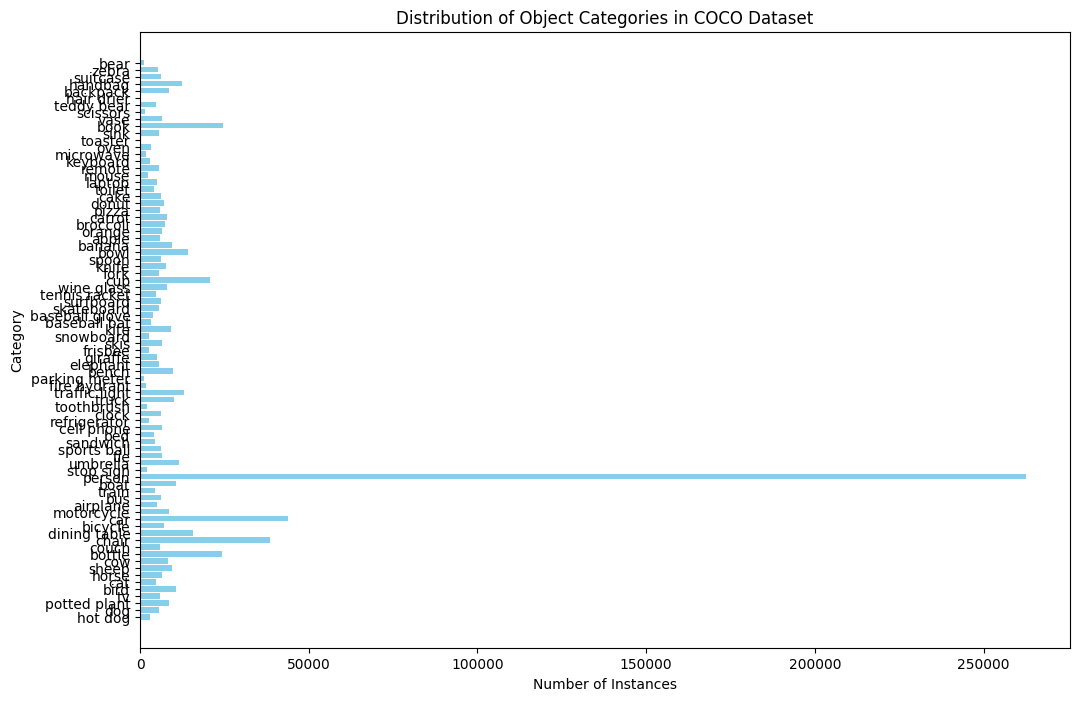

In [ ]:
import json
import matplotlib.pyplot as plt
from collections import Counter

# Load COCO annotations
with open('./data/COCO/annotations/instances_train2017.json') as f:
    annotations = json.load(f)

# Get all category labels
category_mapping = {cat['id']: cat['name'] for cat in annotations['categories']}

# Count object types (category IDs) in the dataset
category_ids = [ann['category_id'] for ann in annotations['annotations']]
category_counts = Counter(category_ids)

# Create a bar chart for the top object categories
category_names = [category_mapping[cat_id] for cat_id in category_counts.keys()]
category_values = list(category_counts.values())

plt.figure(figsize=(12, 8))
plt.barh(category_names, category_values, color='skyblue')
plt.title('Distribution of Object Categories in COCO Dataset')
plt.xlabel('Number of Instances')
plt.ylabel('Category')
plt.show()


In [ ]:
import pandas as pd
import json
from collections import Counter

with open('./data/COCO/annotations/instances_train2017.json') as f:
    annotations = json.load(f)

category_mapping = {cat['id']: cat['name'] for cat in annotations['categories']}
category_ids = [ann['category_id'] for ann in annotations['annotations']]
category_counts = Counter(category_ids)

category_names = [category_mapping[cat_id] for cat_id in category_counts.keys()]
category_values = list(category_counts.values())
df = pd.DataFrame({
    'Category': category_names,
    'Number of Instances': category_values
})

df_sorted = df.sort_values(by='Number of Instances', ascending=False)
print(df_sorted)
df_sorted.style.set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', 'skyblue')]}]
)


         Category  Number of Instances
20         person               262465
14            car                43867
11          chair                38491
70           book                24715
9          bottle                24342
..            ...                  ...
72       scissors                 1481
79           bear                 1294
34  parking meter                 1285
68        toaster                  225
74     hair drier                  198

[80 rows x 2 columns]


,Category,Number of Instances
20,person,262465
14,car,43867
11,chair,38491
70,book,24715
9,bottle,24342
48,cup,20650
12,dining table,15714
52,bowl,14358
32,traffic light,12884
76,handbag,12354


In [ ]:
from PIL import Image
from torchvision import transforms

# Preprocessing pipeline for COCO images
preprocess = transforms.Compose([
    transforms.Resize((416, 416)),   # Resize image to 416x416 (YOLO input size)
    transforms.RandomHorizontalFlip(),  # Data augmentation: random flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Augmentation: color adjustments
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (for ImageNet pre-trained models)
])

# Example: Preprocess an image
image_path = './data/COCO/train2017/000000111806.jpg'
image = Image.open(image_path)
image_preprocessed = preprocess(image)


In [ ]:
!git clone https://github.com/ultralytics/yolov5  # Clone YOLOv5 repository


Cloning into 'yolov5'...
remote: Enumerating objects: 16960, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 16960 (delta 78), reused 99 (delta 49), pack-reused 16805 (from 1)
Receiving objects: 100% (16960/16960), 15.71 MiB | 33.11 MiB/s, done.
Resolving deltas: 100% (11611/11611), done.


In [ ]:
%cd yolov5


/content/yolov5


In [ ]:
!pip install -r requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.6/873.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
import sys
sys.path.append('.')  # Ensure you are in the yolov5 directory
from models.experimental import attempt_load  # Adjust import as necessary


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-9-22 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 488x640 2 persons, 2 elephants
Speed: 19.2ms pre-process, 61.2ms inference, 2.2ms NMS per image at shape (1, 3, 512, 640)


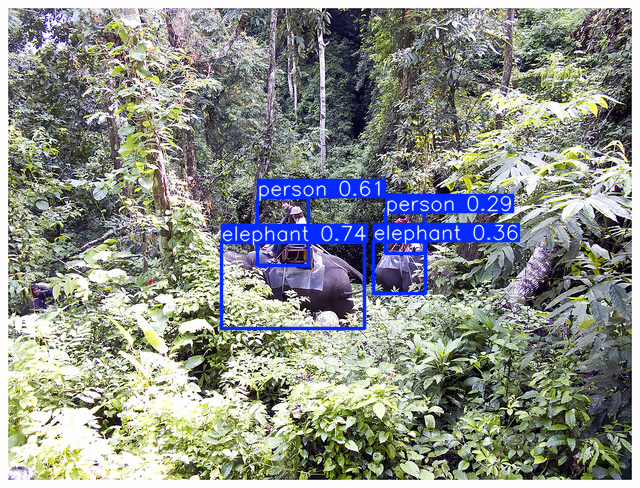

Saved 1 image to runs/detect/exp5


In [ ]:
import torch
from PIL import Image
# Load the YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
image_path = './data/COCO/train2017/000000000061.jpg'
image = Image.open(image_path)
results = model(image)
results.print()
results.show()
results.save('output.jpg')

In [ ]:
import torch

# Define training parameters
data_config = './data/coco.yaml'
weights_path = 'yolov5s.pt'
epochs = 5
# Start training the model
!python train.py --img 640 --batch 16 --epochs {epochs} --data {data_config} --weights {weights_path}


train: weights=yolov5s.pt, cfg=, data=./data/coco.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-368-gb163ff8d Python-3.10.12 torch-2.4.0+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t